# Temporal Generative Adversarial Nets with Singular Value Clipping

In [1]:
!echo Installing Library to Display gifs:
!pip install moviepy
!echo Downloading pre-trained weights
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mk9JdmJH79_vtQkl8zk-jDxa7xUXpck-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1mk9JdmJH79_vtQkl8zk-jDxa7xUXpck-" -O state_normal81000.ckpt && rm -rf /tmp/cookies.txt

Installing Library to Display gifs:
--2022-01-26 22:50:26--  https://docs.google.com/uc?export=download&confirm=aKVe&id=1mk9JdmJH79_vtQkl8zk-jDxa7xUXpck-
Resolving docs.google.com (docs.google.com)... 74.125.195.100, 74.125.195.138, 74.125.195.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-0k-docs.googleusercontent.com/docs/securesc/m5i46n64pr0emmcegvtlcchj0ornktrf/10lpqi8n1nva2hnfo44hoeef5tf4hmfs/1643237400000/14637487104375540506/02496650764157017792Z/1mk9JdmJH79_vtQkl8zk-jDxa7xUXpck-?e=download [following]
--2022-01-26 22:50:26--  https://doc-0s-0k-docs.googleusercontent.com/docs/securesc/m5i46n64pr0emmcegvtlcchj0ornktrf/10lpqi8n1nva2hnfo44hoeef5tf4hmfs/1643237400000/14637487104375540506/02496650764157017792Z/1mk9JdmJH79_vtQkl8zk-jDxa7xUXpck-?e=download
Resolving doc-0s-0k-docs.googleusercontent.com (doc-0s-0k-docs.googleusercontent.com)... 74.125.195.13

In [2]:
import torch
import torch.nn as nn
import numpy as np
from moviepy.editor import ImageSequenceClip
from IPython.display import Image

def genSamples(g, n=8):
    '''
    Generate an n by n grid of videos, given a generator g
    '''
    with torch.no_grad():
        s = g(torch.rand((n**2, 100), device='cuda')*2-1).cpu().detach().numpy()
    
    out = np.zeros((3, 16, 64*n, 64*n))
    
    for j in range(n):
        for k in range(n):
            out[:, :, 64*j:64*(j+1), 64*k:64*(k+1)] = s[j*n+k, :, :, :, :]

    
    out = out.transpose((1, 2, 3, 0))
    out = (out + 1) / 2 * 255
    out = out.astype(int)
    clip = ImageSequenceClip(list(out), fps=20)
    clip.write_gif('sample.gif', fps=20)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2097152/45929032 bytes (4.6%)4055040/45929032 bytes (8.8%)6717440/45929032 bytes (14.6%)9453568/45929032 bytes (20.6%)11862016/45929032 bytes (25.8%)14016512/45929032 bytes (30.5%)16056320/45929032 bytes (35.0%)17637376/45929032 bytes (38.4%)20570112/45929032 bytes (44.8%)23879680/45929032 bytes (52.0%)26255360/45929032 bytes (57.2%)29040640/45929032 bytes (63.2%)317

In [3]:
class TemporalGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Create a sequential model to turn one vector into 16
        self.model = nn.Sequential(
            nn.ConvTranspose1d(100, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 100, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

        # initialize weights according to paper
        self.model.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.ConvTranspose1d:
            nn.init.xavier_uniform_(m.weight, gain=2**0.5)

    def forward(self, x):
        # reshape x so that it can have convolutions done 
        x = x.view(-1, 100, 1)
        # apply the model and flip the 
        x = self.model(x).transpose(1, 2)
        return x

In [4]:
class VideoGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # instantiate the temporal generator
        self.temp = TemporalGenerator()

        # create a transformation for the temporal vectors
        self.fast = nn.Sequential(
            nn.Linear(100, 256 * 4**2, bias=False),
            nn.BatchNorm1d(256 * 4**2),
            nn.ReLU()
        )

        # create a transformation for the content vector
        self.slow = nn.Sequential(
            nn.Linear(100, 256 * 4**2, bias=False),
            nn.BatchNorm1d(256 * 4**2),
            nn.ReLU()
        )


        # define the image generator
        self.model = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        # initialize weights according to the paper
        self.fast.apply(self.init_weights)
        self.slow.apply(self.init_weights)
        self.model.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.ConvTranspose2d or type(m) == nn.Linear:
            nn.init.uniform_(m.weight, a=-0.01, b=0.01)

    def forward(self, x):
        # pass our latent vector through the temporal generator and reshape
        z_fast = self.temp(x).contiguous()
        z_fast = z_fast.view(-1, 100)

        # transform the content and temporal vectors 
        z_fast = self.fast(z_fast).view(-1, 256, 4, 4)
        z_slow = self.slow(x).view(-1, 256, 4, 4).unsqueeze(1)
        # after z_slow is transformed and expanded we can duplicate it
        z_slow = torch.cat([z_slow]*16, dim=1).view(-1, 256, 4, 4)

        # concatenate the temporal and content vectors
        z = torch.cat([z_slow, z_fast], dim=1)

        # transform into image frames
        out = self.model(z)

        return out.view(-1, 16, 3, 64, 64).transpose(1, 2)

In [5]:
class VideoDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model3d = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=4, padding=1, stride=2),
            nn.LeakyReLU(0.2),
            nn.Conv3d(64, 128, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2),
            nn.Conv3d(128, 256, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2),
            nn.Conv3d(256, 512, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm3d(512),
            nn.LeakyReLU(0.2)
        )

        self.conv2d = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)

        # initialize weights according to paper
        self.model3d.apply(self.init_weights)
        self.init_weights(self.conv2d)

    def init_weights(self, m):
        if type(m) == nn.Conv3d or type(m) == nn.Conv2d:
            nn.init.xavier_normal_(m.weight, gain=2**0.5)

    def forward(self, x):
        h = self.model3d(x)
        # turn a tensor of R^NxTxCxHxW into R^NxCxHxW
        h = torch.reshape(h, (32, 512, 4, 4))
        h = self.conv2d(h)
        return h

In [6]:
# instantiate the generator, load the weights, and create a sample
gen = VideoGenerator().cuda()
gen.load_state_dict(torch.load('state_normal81000.ckpt')['model_state_dict'][0])
genSamples(gen)


[MoviePy] Building file sample.gif with imageio


100%|██████████| 17/17 [00:02<00:00,  5.84it/s]


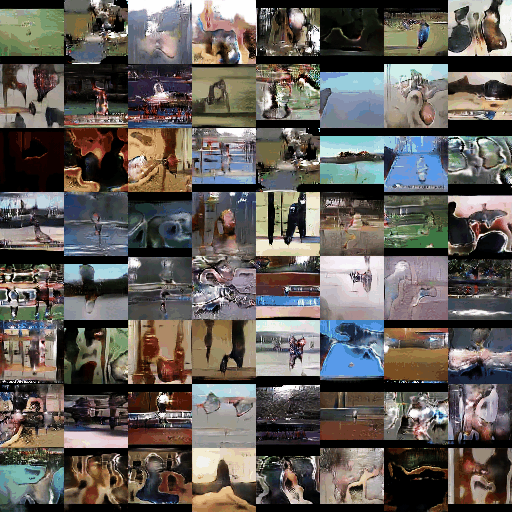

In [7]:
# Run this cell to see results!
Image(open('sample.gif', 'rb').read())